<a href="https://colab.research.google.com/github/Chethan-Kumar9845/Plastic-Waste-Detection/blob/main/Plastic_Waste_Detection_Using_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
!pip install --upgrade gdown

import gdown
import zipfile

file_id = "18pI0FdziEH-pm-eyf49dbqI062OYwIrJ"
download_url = f"https://drive.google.com/uc?id={file_id}"
output_zip = "Dataset.zip"

gdown.download(download_url, output_zip, quiet=False)

with zipfile.ZipFile(output_zip, "r") as zip_ref:
    zip_ref.extractall("plastic_dataset")

print("Dataset downloaded and extracted to 'plastic_dataset' folder.")


Downloading...
From (original): https://drive.google.com/uc?id=18pI0FdziEH-pm-eyf49dbqI062OYwIrJ
From (redirected): https://drive.google.com/uc?id=18pI0FdziEH-pm-eyf49dbqI062OYwIrJ&confirm=t&uuid=bb942b02-28c9-4402-8dd1-c3ad17582c93
To: /content/yolov5/yolov5/yolov5/Dataset.zip
100%|██████████| 186M/186M [00:02<00:00, 73.7MB/s]


Dataset downloaded and extracted to 'plastic_dataset' folder.


In [161]:
import os

# List all items (including folders and files) in plastic_dataset
print("plastic_dataset contents:", os.listdir('plastic_dataset'))

# List all items in plastic_images (should show your files/folders)
print("plastic_images contents:", os.listdir('plastic_dataset/plastic_images'))


plastic_dataset contents: ['plastic_annotation', 'plastic_images']
plastic_images contents: ['plastic_images']


In [162]:
image_folder = 'plastic_dataset/plastic_images/plastic_images'


In [163]:
for root, dirs, files in os.walk('plastic_dataset'):
    for file in files:
        if file.lower().endswith(('.jpg','.jpeg','.png')):
            print(os.path.join(root, file))


plastic_dataset/plastic_images/plastic_images/dc_plastic_000047_gvtD3ib7.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000064_BTTPGrYi.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000045_PhlFazHo.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000014_0ZQvgsAb.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000068_UNZOfV6a.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000041_4WPTKNjc.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000011_ivDUJgCA.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000069_Ig1O3gD6.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000049_kpGAfuhx.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000065_NRkSZPKR.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000036_dRmEoXEM.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000056_rlY65QjG.jpg
plastic_dataset/plastic_images/plastic_images/dc_plastic_000051_Pejn1hn6.jpg

In [164]:
image_folder = 'plastic_dataset/plastic_images/plastic_images'
img_list = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]

print("Total images:", len(img_list))
print("First 5 images:", img_list[:5])


Total images: 71
First 5 images: ['dc_plastic_000047_gvtD3ib7.jpg', 'dc_plastic_000064_BTTPGrYi.jpg', 'dc_plastic_000045_PhlFazHo.jpg', 'dc_plastic_000014_0ZQvgsAb.jpg', 'dc_plastic_000068_UNZOfV6a.jpg']


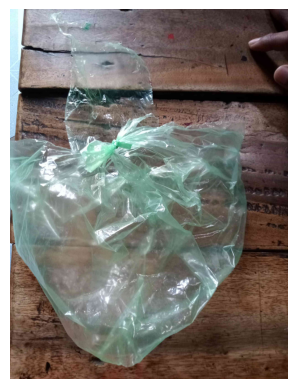

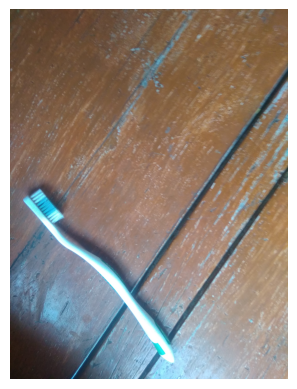

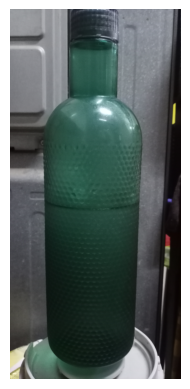

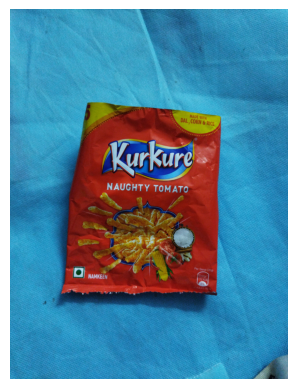

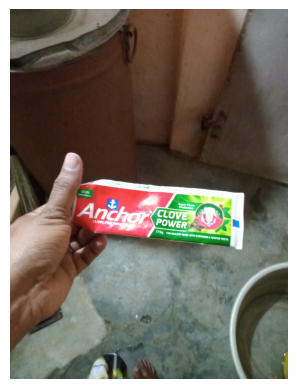

In [165]:
from PIL import Image
import matplotlib.pyplot as plt
import os

for i in range(5):
    img_path = os.path.join(image_folder, img_list[i])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()



In [166]:
import os

annotation_folder = 'plastic_dataset/plastic_annotation'
annotation_files = os.listdir(annotation_folder)
print("Total annotation files:", len(annotation_files))
print("First 5 annotation files:", annotation_files[:5])


Total annotation files: 1
First 5 annotation files: ['plastic_annotation']


In [167]:
import os

annotation_folder = 'plastic_dataset/plastic_annotation/plastic_annotation'
annotation_files = os.listdir(annotation_folder)

print("Total annotation files:", len(annotation_files))
print("First 5 annotation files:", annotation_files[:5])

file_path = os.path.join(annotation_folder, annotation_files[0])
with open(file_path, 'r') as f:
    data = f.read()
print(data[:500])  # Print first 500 characters to inspect the structure


Total annotation files: 70
First 5 annotation files: ['dc_plastic_000025_RFAKG2Ce.xml', 'dc_plastic_000057_1lgwf9Mp.xml', 'dc_plastic_000051_Pejn1hn6.xml', 'dc_plastic_000034_yTc8ToTd.xml', 'dc_plastic_000031_GyvGmqct.xml']
<annotation>
  <folder>dc</folder>
  <filename>dc_plastic_000025_RFAKG2Ce.jpg</filename>
  <source>
    <database>Unknown</database>
    <annotation>Unknown</annotation>
    <image>Unknown</image>
  </source>
  <size>
    <width>2448</width>
    <height>3264</height>
    <depth></depth>
  </size>
  <segmented>0</segmented>
  <object>
    <name>plastic</name>
    <truncated>0</truncated>
    <occluded>0</occluded>
    <difficult>0</difficult>
    <bndbox>
      <xmin>903.36</xmin>
      <ymin>627


In [168]:
import os
import xml.etree.ElementTree as ET

annotation_folder = 'plastic_dataset/plastic_annotation/plastic_annotation'
annotation_files = os.listdir(annotation_folder)

# Example: Parse first annotation file
file_path = os.path.join(annotation_folder, annotation_files[0])
tree = ET.parse(file_path)
root = tree.getroot()

# Get image filename
filename = root.find('filename').text

# Get object details
for obj in root.findall('object'):
    label = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = float(bndbox.find('xmin').text)
    ymin = float(bndbox.find('ymin').text)
    xmax = float(bndbox.find('xmax').text) if bndbox.find('xmax') is not None else None
    ymax = float(bndbox.find('ymax').text) if bndbox.find('ymax') is not None else None
    print(f"Filename: {filename}, Label: {label}, BoundingBox: ({xmin}, {ymin}), ({xmax}, {ymax})")


Filename: dc_plastic_000025_RFAKG2Ce.jpg, Label: plastic, BoundingBox: (903.36, 627.16), (2094.9, 1741.83)


In [169]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

annotation_folder = 'plastic_dataset/plastic_annotation/plastic_annotation'
annotation_files = os.listdir(annotation_folder)

data_list = []

for ann_file in annotation_files:
    file_path = os.path.join(annotation_folder, ann_file)
    tree = ET.parse(file_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text) if bndbox.find('xmax') is not None else None
        ymax = float(bndbox.find('ymax').text) if bndbox.find('ymax') is not None else None
        data_list.append([filename, label, xmin, ymin, xmax, ymax])

# Convert to DataFrame
df = pd.DataFrame(data_list, columns=['filename', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])
print(df.head())


                         filename    label     xmin    ymin     xmax     ymax
0  dc_plastic_000025_RFAKG2Ce.jpg  plastic   903.36  627.16  2094.90  1741.83
1  dc_plastic_000057_1lgwf9Mp.jpg  plastic  1008.40  878.30  1892.15  2345.25
2  dc_plastic_000051_Pejn1hn6.jpg  plastic   503.18  547.98  1761.71  2406.12
3  dc_plastic_000034_yTc8ToTd.jpg  plastic   553.72  891.51  2352.56  2747.32
4  dc_plastic_000031_GyvGmqct.jpg  plastic   404.46  860.40  2389.50  3008.07


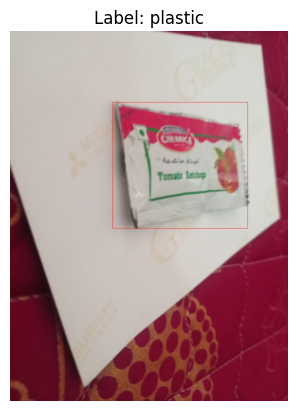

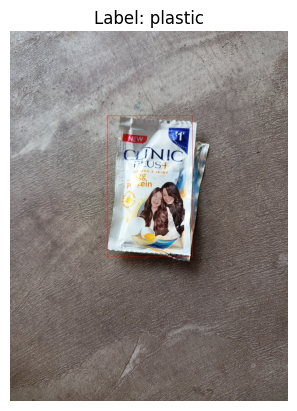

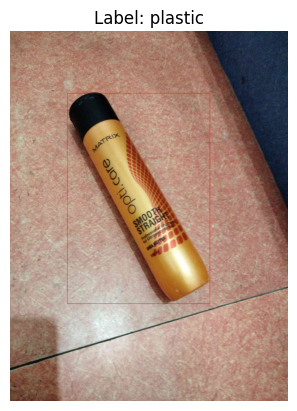

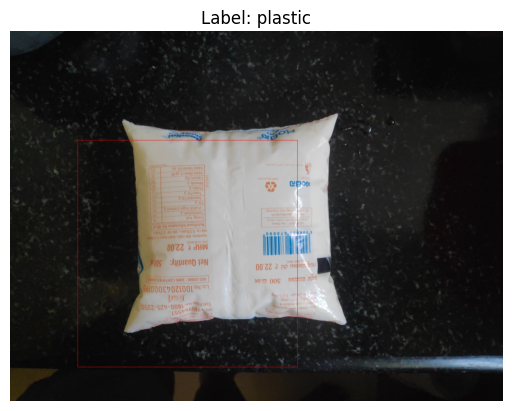

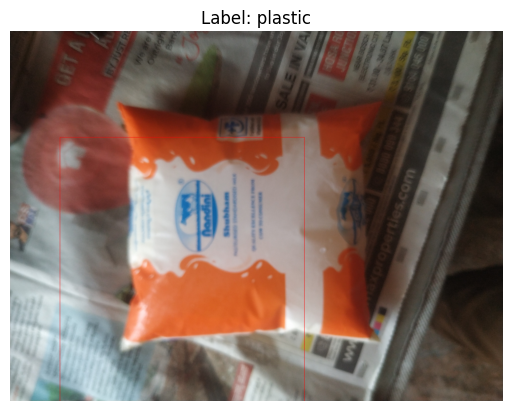

In [170]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image_folder = 'plastic_dataset/plastic_images/plastic_images'

for i in range(5):  # Display first 5 images with bounding boxes
    row = df.iloc[i]
    img_path = os.path.join(image_folder, row['filename'])
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    # Draw box
    draw.rectangle([row['xmin'], row['ymin'], row['xmax'], row['ymax']], outline='red', width=3)
    plt.imshow(img)
    plt.title(f"Label: {row['label']}")
    plt.axis('off')
    plt.show()


In [171]:
from sklearn.model_selection import train_test_split

# Split based on unique filenames to avoid data leakage
unique_files = df['filename'].unique()
train_files, test_files = train_test_split(unique_files, test_size=0.2, random_state=42)

# Create train and test DataFrame subsets
train_df = df[df['filename'].isin(train_files)].reset_index(drop=True)
test_df = df[df['filename'].isin(test_files)].reset_index(drop=True)

print("Training samples:", len(train_df))
print("Testing samples:", len(test_df))


Training samples: 62
Testing samples: 14


In [172]:
import os
import shutil

os.makedirs('yolo_dataset/images/val', exist_ok=True)

# Move uploaded files to validation images folder
for filename in uploaded.keys():
    shutil.move(filename, f'yolo_dataset/images/val/{filename}')


In [173]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17564, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 17564 (delta 33), reused 7 (delta 7), pack-reused 17510 (from 4)
Receiving objects: 100% (17564/17564), 16.69 MiB | 24.73 MiB/s, done.
Resolving deltas: 100% (12031/12031), done.
/content/yolov5/yolov5/yolov5


In [174]:
custom_data = """
train: ../yolo_dataset/images/train
val: ../yolo_dataset/images/val

nc: 1
names: ['plastic']
"""

with open('custom_data.yaml', 'w') as f:
    f.write(custom_data)


In [179]:
import os
from PIL import Image

def convert_to_yolo(df, img_folder, save_folder):
    os.makedirs(save_folder, exist_ok=True)
    grouped = df.groupby('filename')
    for filename, group in grouped:
        img_path = os.path.join(img_folder, filename)
        img = Image.open(img_path)
        img_width, img_height = img.size
        txt_filename = os.path.splitext(filename)[0] + '.txt'
        txt_path = os.path.join(save_folder, txt_filename)

        with open(txt_path, 'w') as f:
            for _, row in group.iterrows():
                x_center = ((row['xmin'] + row['xmax']) / 2) / img_width
                y_center = ((row['ymin'] + row['ymax']) / 2) / img_height
                width = (row['xmax'] - row['xmin']) / img_width
                height = (row['ymax'] - row['ymin']) / img_height
                f.write(f"0 {x_center} {y_center} {width} {height}\n")  # '0' is class index for plastic


In [181]:
import os

# Paths for label folders where YOLO txt labels will be saved
label_train_folder = 'yolo_dataset/labels/train'
label_val_folder = 'yolo_dataset/labels/val'

# Paths for images copied into YOLOv5 format
image_train_folder = 'yolo_dataset/images/train'
image_val_folder = 'yolo_dataset/images/val'

# Create all necessary directories if they don't exist
os.makedirs(label_train_folder, exist_ok=True)
os.makedirs(label_val_folder, exist_ok=True)
os.makedirs(image_train_folder, exist_ok=True)
os.makedirs(image_val_folder, exist_ok=True)

print(f"Directories ensured:\n{label_train_folder}\n{label_val_folder}\n{image_train_folder}\n{image_val_folder}")


Directories ensured:
yolo_dataset/labels/train
yolo_dataset/labels/val
yolo_dataset/images/train
yolo_dataset/images/val


In [187]:
import os

print("yolo_dataset contents:", os.listdir('yolo_dataset'))
# If there are subfolders
for root, dirs, files in os.walk('yolo_dataset'):
    print("Root:", root)
    for d in dirs:
        print(" - Dir:", d)
    for f in files[:5]:  # Show sample files
        print("   * File:", f)


yolo_dataset contents: ['labels', 'images']
Root: yolo_dataset
 - Dir: labels
 - Dir: images
Root: yolo_dataset/labels
 - Dir: val
 - Dir: train
Root: yolo_dataset/labels/val
Root: yolo_dataset/labels/train
Root: yolo_dataset/images
 - Dir: val
 - Dir: train
Root: yolo_dataset/images/val
Root: yolo_dataset/images/train


In [190]:
image_train_folder = 'yolo_dataset/images/train'
image_val_folder = 'yolo_dataset/images/val'
label_train_folder = 'yolo_dataset/labels/train'
label_val_folder = 'yolo_dataset/labels/val'


In [194]:
import os

# Get all present image filenames in train and val folders
existing_train_images = set(os.listdir(image_train_folder))
existing_val_images = set(os.listdir(image_val_folder))

# Filter train/test df to only include images that exist in relevant folders
filtered_train_df = train_df[train_df['filename'].isin(existing_train_images)].reset_index(drop=True)
filtered_test_df = test_df[test_df['filename'].isin(existing_val_images)].reset_index(drop=True)

# Convert only for images that are present
convert_to_yolo(filtered_train_df, image_train_folder, label_train_folder)
convert_to_yolo(filtered_test_df, image_val_folder, label_val_folder)


In [196]:
convert_to_yolo(filtered_train_df, image_train_folder, label_train_folder)
convert_to_yolo(filtered_test_df, image_val_folder, label_val_folder)


In [211]:
import shutil
import os

original_image_folder = 'plastic_dataset/plastic_images/plastic_images'

# Copy training images based on train_df (unfiltered)
for img_file in train_df['filename'].unique():
    src = os.path.join(original_image_folder, img_file)
    dst = os.path.join('yolo_dataset/images/train', img_file)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"Missing train file: {src}")

# Copy validation images based on test_df (unfiltered)
for img_file in test_df['filename'].unique():
    src = os.path.join(original_image_folder, img_file)
    dst = os.path.join('yolo_dataset/images/val', img_file)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"Missing val file: {src}")


In [212]:
print("Train images after copy:", os.listdir('yolo_dataset/images/train')[:5])
print("Val images after copy:", os.listdir('yolo_dataset/images/val')[:5])


Train images after copy: ['dc_plastic_000047_gvtD3ib7.jpg', 'dc_plastic_000064_BTTPGrYi.jpg', 'dc_plastic_000045_PhlFazHo.jpg', 'dc_plastic_000014_0ZQvgsAb.jpg', 'dc_plastic_000068_UNZOfV6a.jpg']
Val images after copy: ['dc_plastic_000041_4WPTKNjc.jpg', 'dc_plastic_000043_SrWFpmle.jpg', 'dc_plastic_000002_Cbz9fzUQ.jpg', 'dc_plastic_000018_GoOCYIVN.jpg', 'dc_plastic_000031_GyvGmqct.jpg']


In [214]:
convert_to_yolo(train_df, original_image_folder, label_train_folder)
convert_to_yolo(test_df, original_image_folder, label_val_folder)


In [215]:
print("Train images:", os.listdir('yolo_dataset/images/train'))
print("Val images:", os.listdir('yolo_dataset/images/val'))


Train images: ['dc_plastic_000047_gvtD3ib7.jpg', 'dc_plastic_000064_BTTPGrYi.jpg', 'dc_plastic_000045_PhlFazHo.jpg', 'dc_plastic_000014_0ZQvgsAb.jpg', 'dc_plastic_000068_UNZOfV6a.jpg', 'dc_plastic_000011_ivDUJgCA.jpg', 'dc_plastic_000069_Ig1O3gD6.jpg', 'dc_plastic_000049_kpGAfuhx.jpg', 'dc_plastic_000065_NRkSZPKR.jpg', 'dc_plastic_000036_dRmEoXEM.jpg', 'dc_plastic_000056_rlY65QjG.jpg', 'dc_plastic_000051_Pejn1hn6.jpg', 'dc_plastic_000021_zV4DE7hY.jpg', 'dc_plastic_000040_JdwIj3QC.jpg', 'dc_plastic_000029_EYLTs3Rw.jpg', 'dc_plastic_000013_rJUVky4O.jpg', 'dc_plastic_000010_TleUeK2v.jpg', 'dc_plastic_000061_z1ngjdlz.jpg', 'dc_plastic_000007_FplCVcaI.jpg', 'dc_plastic_000028_QhB6eYcQ.jpg', 'dc_plastic_000016_ceTnQFul.jpg', 'dc_plastic_000060_AXkoooRY.jpg', 'dc_plastic_000009_sQWHZRn1.jpg', 'dc_plastic_000019_KYmVNl3T.jpg', 'dc_plastic_000053_P5HeojNb.jpg', 'dc_plastic_000030_w6f4yUiS.jpg', 'dc_plastic_000062_dk7BmLef.jpg', 'dc_plastic_000004_ucYMNdCT.jpg', 'dc_plastic_000008_yoLvadEZ.jpg',

In [217]:
custom_data = """
train: yolo_dataset/images/train
val: yolo_dataset/images/val
nc: 1
names: ['plastic']
"""
with open('custom_data.yaml', 'w') as f:
    f.write(custom_data)


In [218]:
!python train.py --img 640 --batch 16 --epochs 20 --data custom_data.yaml --weights yolov5s.pt --cache


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-08-31 14:38:04.751384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756651084.788434   71648 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756651084.799946   71648 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756651084.830295   71648 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756651084.830377   71648 computation_placer.cc:177] computation placer already registere

In [ ]:
!python detect.py --weights runs/train/exp3/weights/best.pt --img 640 --conf 0.10 --source yolo_dataset/images/val --project runs/detect --name val_results --exist-ok


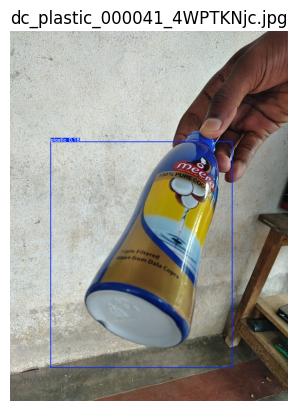

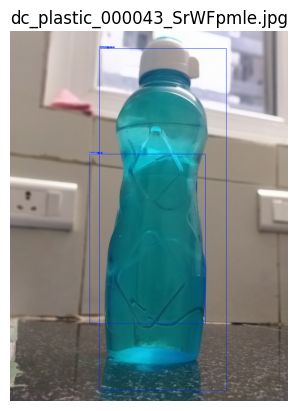

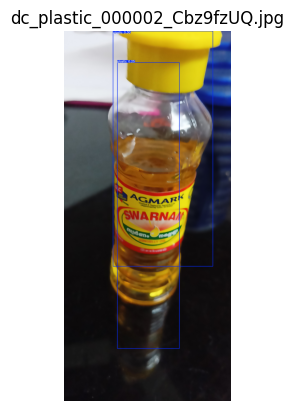

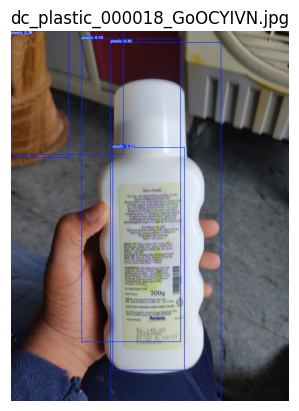

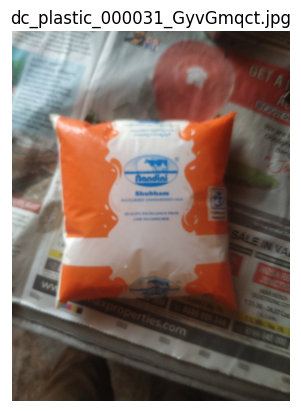

In [223]:
from PIL import Image
import matplotlib.pyplot as plt
import os

results_folder = 'runs/detect/val_results'
images = [f for f in os.listdir(results_folder) if f.endswith('.jpg')]

for image in images[:5]:
    img_path = os.path.join(results_folder, image)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image)
    plt.show()
